## Imports

In [119]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pickle
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_model_optimization as tfmot
import RadixNetFuncs
from RadixNetCalc import emr_net, kemr_net
import matlab.engine
import math
import networkx as nx

print("libraries imported")

libraries imported


### Load datasets

#### MNIST

In [120]:
data = pd.read_csv("MNIST/mnist_train.csv") #mnist train
test = pd.read_csv("MNIST/mnist_test.csv") #mnist test

data = np.array(data)

np.random.seed(100) # change this for different shuffling order
np.random.shuffle(data) 

data_train = data.T
Y_train = np.array(data_train[0])
X_train = np.array(data_train[1:]).T
X_train = X_train / 255

test = np.array(test)
data_test = test.T
Y_test = np.array(data_test[0])
X_test = np.array(data_test[1:]).T
X_test = X_test / 255

print("MNIST train: ", X_train.shape, Y_train.shape)
print("MNIST test: ", X_test.shape, Y_test.shape)

MNIST train:  (42000, 784) (42000,)
MNIST test:  (9999, 784) (9999,)


#### CIFAR-10

In [5]:
"""

def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='latin1')  # Use 'latin1' encoding for Python 3
    return data

def load_cifar10_dataset(directory):
    train_data = []
    train_labels = []
    for batch in range(5):
        batch_data = unpickle(os.path.join(directory, "data_batch_"+str(batch+1)))
        train_data.extend(batch_data['data'])
        train_labels.extend(batch_data['labels'])

    train_data = np.array(train_data)
    train_labels = np.array(train_labels)

    # Load test data
    test_data = unpickle(os.path.join(directory, "test_batch"))
    test_inputs = np.array(test_data['data'])
    test_labels = np.array(test_data['labels'])

    return train_data, train_labels, test_inputs, test_labels

data_dir = "CIFAR-10/"
X_train, Y_train, X_test, Y_test = load_cifar10_dataset(data_dir)
print("CIFAR-10 train: ", X_train.shape, Y_train.shape)
print("CIFAR-10 test: ", X_test.shape, Y_test.shape)"""

'\n\ndef unpickle(file):\n    with open(file, \'rb\') as fo:\n        data = pickle.load(fo, encoding=\'latin1\')  # Use \'latin1\' encoding for Python 3\n    return data\n\ndef load_cifar10_dataset(directory):\n    train_data = []\n    train_labels = []\n    for batch in range(5):\n        batch_data = unpickle(os.path.join(directory, "data_batch_"+str(batch+1)))\n        train_data.extend(batch_data[\'data\'])\n        train_labels.extend(batch_data[\'labels\'])\n\n    train_data = np.array(train_data)\n    train_labels = np.array(train_labels)\n\n    # Load test data\n    test_data = unpickle(os.path.join(directory, "test_batch"))\n    test_inputs = np.array(test_data[\'data\'])\n    test_labels = np.array(test_data[\'labels\'])\n\n    return train_data, train_labels, test_inputs, test_labels\n\ndata_dir = "CIFAR-10/"\nX_train, Y_train, X_test, Y_test = load_cifar10_dataset(data_dir)\nprint("CIFAR-10 train: ", X_train.shape, Y_train.shape)\nprint("CIFAR-10 test: ", X_test.shape, Y_t

## Custom Radix Layer implementation
Applies a sparse mask during training iterations to maintain sparsity
Create using Mask(num_output, input_shape, radix), call using maskname()

In [122]:
class Mask(tf.Module):
    """
    A class used to create tensorflow masks that represent the RadiXNet weight masks. 
    They are used to be applied at every call of a RadixLayer, specifically at every step of training.
    ...
    Attributes
    ----------
    val : None or tf.Variable
        keeps track of what the mask is in a tensorflow format, kept as None to start with 
        but is changed the first time it's called
    layerval : np.array
        input of what the mask should be in a numpy array format.
    """
    def __init__(self,layerval:np.array):
        """
        Used to construct a Mask, but doesn't have the correct shape yet.
        Inputs:
        layerval : np.array
            input of what the mask should be in a numpy array format
        """
        self.val=None
        self.layerval = layerval
    @tf.function
    def __call__(self):
        """
        Used whenever you want to actually use the mask
        Example of usage:
            mask = Mask(layerval) #create the mask
            tf.math.multiply(kernel, mask()) #calling the mask
        """
        if self.val is None:
            #arr = np.zeros(self.input_shape[1:]+(self.num_outputs,))
            arr = self.layerval
            tensor = tf.constant(arr, dtype= tf.float32)
            self.val = tf.Variable(tensor)
        return self.val

class RadixLayer(layers.Layer):
    """
    A class used to create layers of a RadiXNet, made for an easier implementation of RadiXNets
    ...
    Attributes
    ----------
    num_outputs : int
        the number of outputs that the layer should have, or how many neurons are in the next layer
    layerval : numpy array
        input of what the mask should be in a numpy array format
    activation : function
        activation function used
    kernel : tensorflow Variable
        the values of the layer that will be trained
    """
    def __init__(self, num_outputs:int, layerval:np.array, activation = tf.nn.relu):
        """
        Used to construct a RadixLayer
        Inputs:
        num_outputs : int
            number of outputs that layer should have
        layerval : numpy array
            input of what the mask should be
        activation : function
            activation type, defaults to relu function
        """
        super(RadixLayer,self).__init__()
        self.num_outputs = num_outputs
        self.layerval = layerval
        self.activation = activation
    def build(self, input_shape:tuple):
        """
        Used when first creating and calling a RadixLayer, creates the kernel variable
        Inputs:
        input_shape : tuple
            Size of inputs, this is needed in the build function but is currently not used because our kernel 
            shapes should take on the shape of the radix layer
        """
        self.kernel = self.add_weight("kernel", shape = self.layerval.shape, initializer='random_normal', trainable=True)
    def call(self, inputs:tf.Tensor):
        """
        Used whenever the RadixLayer is called during iterations
        Inputs:
        inputs: tensor
            What will be going into the RadiXLayer
        Outputs:
            returns the inputs matrix multiplied with a masked version of the kernel (element wise multiplication between kernel and mask)
        """
        mask = Mask(self.layerval)
        masked = tf.math.multiply(self.kernel,mask())
        #extrazero =  tf.zeros(shape=(self.layerval.shape[0]-inputs.shape[1]), dtype=tf.int32)
        #inputs = tf.concat(inputs,extrazero)
        try:
            return self.activation(tf.matmul(inputs,masked))
        except:
            return None

## Initializing models

### Custom Models

In [174]:
"""
Change N and desired_layer_sizes is to have custom radices and kronecker numbers to fit a specific network
Then adjust CustomModel class to fit in with how many layers you have and what activation functions you want
"""

desired_layer_sizes = [784, 300, 100, 10] #Lenet 300-100 default
N = [[1,1,1]]#[[1,10,10]] # Use RadixNetFuncs.generate_permutations(desired_layer_sizes, radix_list_factors) to generate more possible radix net permutations

""" example usage: 
perms = RadixNetFuncs.generate_permutations(desired_layer_sizes, list(range(1,11))) #run with supercomputer for larger amounts of factors
radix_nets = RadixNetFuncs.build_radix_nets(perms, desired_layers_sizes)
"""

topology = RadixNetFuncs.build_radix_nets([N], desired_layer_sizes)

for layer in topology:
    print(layer.shape)

class CustomModel(tf.keras.Model):
    """
    Class used to customize whatever kind of model the user would like
    ...
    Attributes
    ----------
    layers : RadixLayer
        However many RadixLayers the user would 
        like, take in from rlayers, which is done with kemr_net 
        and trimming to the desired_layer_sizes size
    """
    def __init__(self, topology:list):
        """
        Initialization of layers (choose how many layers you want)
        Inputs:
        topology : list of numpy arrays
            fully created topology from kemr_net and 
            trimmed to fit desired_layer_sizes
        """
        super(CustomModel,self).__init__()
        self.layer1 = RadixLayer(topology[0].shape[-1], 
                                 topology[0],
                                 tf.nn.relu)
        self.layer2 = RadixLayer(topology[1].shape[-1], 
                                 topology[1],
                                 tf.nn.relu)
        self.layer3 = RadixLayer(topology[2].shape[-1], 
                                 topology[2],
                                 tf.nn.softmax)
    def call(self, input_tensor:tf.Tensor):
        """
        Actually does the math and calculates the result of an input through the network.
        Customize what activation functions are used
        Inputs:
        input_tensor : tensor
            the input
        Outputs:
            The result of the calculation
        """
        x = self.layer1(input_tensor)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

(784, 300)
(300, 100)
(100, 10)


### Sequential Models

#### Lenet 300-100 Radix Net

In [175]:
model = tf.keras.Sequential([
    RadixLayer(topology[0].shape[-1], topology[0], activation=tf.nn.relu),
    RadixLayer(topology[1].shape[-1], topology[1], activation=tf.nn.relu),
    RadixLayer(topology[2].shape[-1], topology[2], activation=tf.nn.softmax)
])

## Compiling Model

In [176]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Training

In [177]:
epochs = 5
history = model.fit(X_train,Y_train,epochs = epochs, batch_size = 512,validation_split = 0.1)
print(f"Sparsity: {RadixNetFuncs.calculate_sparsity(topology)*100}%")

Epoch 1/5
74/74 [==============================] - 1s 6ms/step - loss: 0.7470 - accuracy: 0.8052 - val_loss: 0.2917 - val_accuracy: 0.9164
Epoch 2/5
74/74 [==============================] - 0s 4ms/step - loss: 0.2544 - accuracy: 0.9269 - val_loss: 0.2121 - val_accuracy: 0.9424
Epoch 3/5
74/74 [==============================] - 0s 4ms/step - loss: 0.1833 - accuracy: 0.9473 - val_loss: 0.1697 - val_accuracy: 0.9543
Epoch 4/5
74/74 [==============================] - 0s 4ms/step - loss: 0.1434 - accuracy: 0.9589 - val_loss: 0.1448 - val_accuracy: 0.9595
Epoch 5/5
74/74 [==============================] - 0s 4ms/step - loss: 0.1157 - accuracy: 0.9665 - val_loss: 0.1348 - val_accuracy: 0.9621
Sparsity: 0.0%


## Testing

In [178]:
test_loss, test_acc = model.evaluate(X_test, Y_test)

model.summary()

313/313 [==============================] - 0s 898us/step - loss: 0.1037 - accuracy: 0.9692
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 radix_layer_57 (RadixLayer)  (None, 300)              235200    
                                                                 
 radix_layer_58 (RadixLayer)  (None, 100)              30000     
                                                                 
 radix_layer_59 (RadixLayer)  (None, 10)               1000      
                                                                 
Total params: 266,200
Trainable params: 266,200
Non-trainable params: 0
_________________________________________________________________


## Plotting Accuracy & Loss

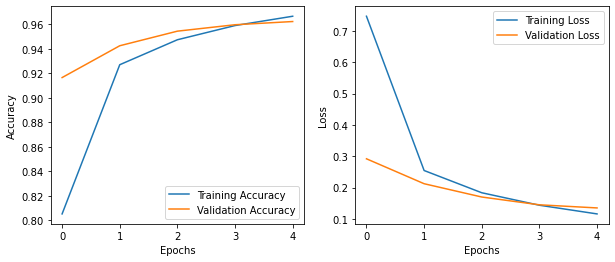

In [179]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Plot Structure (Adjacency Matrix)

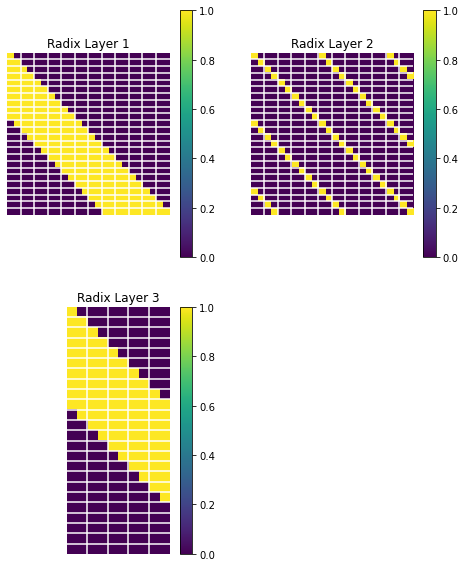

In [106]:
def plot_separation_lines(height:int, width:int):
    """
    Plots white separation lines for the adjacency matrix
    Inputs:
    height : int
        height of what will be plotted for the adjacency matrix
    width : int
        width of what will be plotted for the adjacency matrix
    """
    block_size = [1, 2]

    # Add separation lines to the figure.
    num_hlines = int((height - 1) / block_size[0])
    num_vlines = int((width - 1) / block_size[1])
    line_y_pos = [y * block_size[0] for y in range(1, num_hlines + 1)]
    line_x_pos = [x * block_size[1] for x in range(1, num_vlines + 1)]

    for y_pos in line_y_pos:
        plt.plot([-0.5, width], [y_pos - 0.5 , y_pos - 0.5], color='w')

    for x_pos in line_x_pos:
        plt.plot([x_pos - 0.5, x_pos - 0.5], [-0.5, height], color='w')

def plot_layer(layerarr:list, index:int):
    """
    Plots a specific layer as an adjacency matrix
    Inputs:
    layerarr : list of numpy arr
        list of the the mask of the layers being plotted
    index : int
        gives which layer in the layer array will be plotted
    """
    tensor_data = layerarr[index]
    # The value 24 is chosen for convenience.
    smallest = min(tensor_data.shape[0],tensor_data.shape[1])
    # height = min(24,smallest)
    # width = min(24,smallest)
    height = min(24,tensor_data.shape[0])
    width = min(24,tensor_data.shape[1])
    
    subset_values_to_display = tensor_data[0:height, 0:width]
    
    val_ones = np.ones([height, width])
    val_zeros = np.zeros([height, width])
    subset_values_to_display = np.where(abs(subset_values_to_display) > 0, val_ones, val_zeros)

    plot_separation_lines(height, width)

    plt.axis('off')
    plt.imshow(subset_values_to_display)
    plt.colorbar()
    plt.title("Radix Layer "+str(index+1))

plt.figure(figsize=(math.ceil(len(rlayers)/2)*4, 10))
for i in range(len(rlayers)):
    #print(rlayers[i])
    plt.subplot(math.ceil(len(rlayers)/2),2,i+1)
    plot_layer(rlayers, i)
plt.show()

# tlayers = emr_net(N)
# plt.figure(figsize=(math.ceil(len(tlayers)/2)*4, 10))
# for i in range(len(tlayers)):
#     #print(rlayers[i])
#     plt.subplot(math.ceil(len(tlayers)/2),2,i+1)
#     plot_layer(tlayers, i)
# plt.show()

### Plot Structure (Graphical)

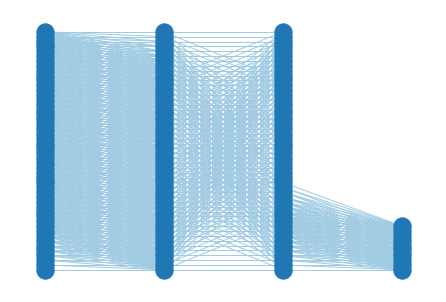

In [184]:
"""
Plots a graphical representation of the RadiXNet, adjust how much you want to see of the network with maxnodes.
Warning: too high of a maxnodes may images that are difficult to decipher where the connections lie.
"""
maxnodes = 50

B = nx.Graph()
pos = dict()
for i in range(len(rlayers)):
    temp = []
    for j in range(min(maxnodes,rlayers[i].shape[0])):
        node = "l"+str(i)+"_"+str(j)
        temp.append(node)
        pos[node]=(i,j)
    B.add_nodes_from(temp)
    
for j in range(min(maxnodes,rlayers[len(rlayers)-1].shape[1])):
        node = "l"+str(len(rlayers))+"_"+str(j)
        temp.append(node)
        pos[node]=(len(rlayers),j)
        B.add_nodes_from([node])

for a in range(len(rlayers)):
    layera = rlayers[a]
    for i in range(min(maxnodes,layera.shape[0])):
        for j in range(min(maxnodes,layera.shape[1])):
            if layera[i][j]:
                nodei = "l"+str(a)+"_"+str(i)
                nodej = "l"+str(a+1)+"_"+str(j)
                B.add_edge(nodei,nodej, color='#A0CBE2')
colors = nx.get_edge_attributes(B,'color').values()
nx.draw(B, pos=pos, edge_color=colors)
plt.show()

## Plot important weights

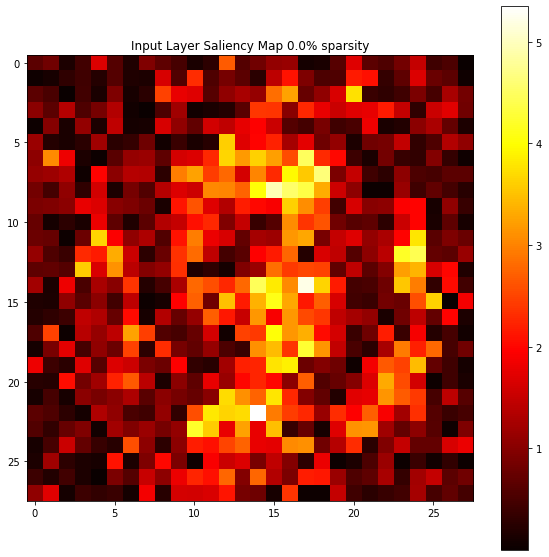

In [185]:
def plot_saliency_map(input_layer): #sums outgoing weights and makes a heat map
    matrix = np.sum(input_layer, axis=1)
    matrix = matrix.reshape(28, 28) # Reshape to 28x28 (mnist) for visualization
    plt.figure(figsize=(10, 10))
    sp = 1 - np.count_nonzero(input_layer) / np.prod(input_layer.shape)
    plt.title(f"Input Layer Saliency Map {sp*100}% sparsity")
    plt.imshow(np.abs(matrix), cmap='hot', interpolation='nearest') # We take the absolute values to highlight large values
    plt.colorbar()
    plt.show()
    
plot_saliency_map(model.layers[0].kernel * model.layers[0].layerval)

### Sanity Check

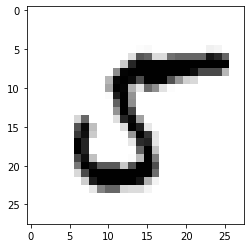

Actual:  5
Prediction:  5


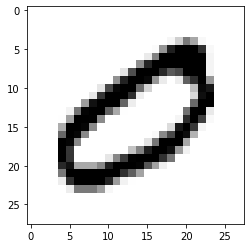

Actual:  0
Prediction:  0


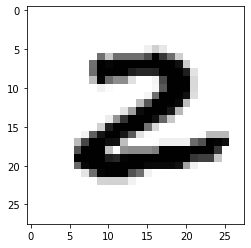

Actual:  2
Prediction:  2


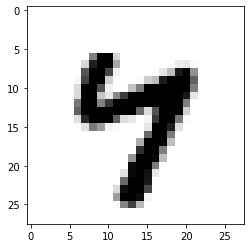

Actual:  4
Prediction:  4


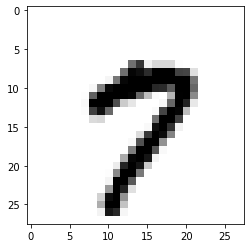

Actual:  7
Prediction:  7


In [186]:
sanity_reassuring_level = 5
predictions = model.predict(np.array([X_train[0:sanity_reassuring_level]]))

for idx in range(sanity_reassuring_level):
    plt.imshow(X_train[idx].reshape(28, 28), cmap=plt.cm.binary)
    plt.show()
    print("Actual: ", Y_train[idx])
    print("Prediction: ", np.argmax(predictions[0][idx]))